# 从零开始搭建扩散模型

本章涵盖的知识点如下：
- 退化过程（向数据添加噪声）
- 什么事UNet网络模型以及如何从零开始实现一个简单的UNet网络模型
- 扩散模型的训练
- 采样理论

然后，本章将介绍我们所展示的模型版本和Diffusers库中DDPM版本实现过程的区别，涵盖的知识点如下：
- 小型UNet网络模型的改进方法
- DDPM噪声计划
- 训练目标的差异
- 调节时间步
- 采样方法

## 1. 环境准备

### 1.1 环境的创建与导入

In [1]:
import torch
import torchvision 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.mps.is_available()
                      else 'cpu')
print(device)

/Users/hongshuo/Diffusion-Model/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hongshuo/Diffusion-Model/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps


### 1.2 数据集测试
我们将使用一个非常小的经典数据集MNIST来进行测试

MNIST数据集中的每张图都是一个阿拉伯数字的 $28\times28$ 像素的灰度图，每个像素的取值区间是[0,1] 

Input Size: torch.Size([8, 1, 28, 28])
Labels tensor([1, 5, 9, 2, 6, 8, 1, 4])


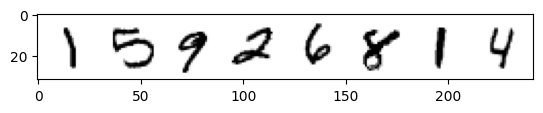

In [2]:
train_dataset = torchvision.datasets.MNIST(root='Datasets/',train=True,download=False,transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)
x,y = next(iter(train_dataloader))
print('Input Size:',x.shape)
print('Labels',y)
plt.imshow(torchvision.utils.make_grid(x)[0],cmap='Greys')

## 2. 扩散模型之退化过程
我们可以通过一个简单的方法来控制内容损坏的程度。如果需要引入一个参数来控制输入的“噪声量”，那么我们可以在配置好的环境中输入如下的代码：

In [3]:
def corrupt(x,amount):
    """
    根据amount的大小为输入x添加噪声,这就是退化过程
    """
    noise = torch.rand_like(x)
    amount = amount.view(-1,1,1,1) # 整理形状以保证广播机制不出错
    return x*(1-amount) + noise*amount

如果 $amount=0$ ，则返回输入，不做任何更改；如果 $amount=1$ ，我们将得到一个纯粹的噪声。通过这种方式，我们可以将输入内容和噪声混合，并把混合后的结果保持在相同的范围内 $0\sim1$。

接下来对结果进行可视化，看看是否符合预期：

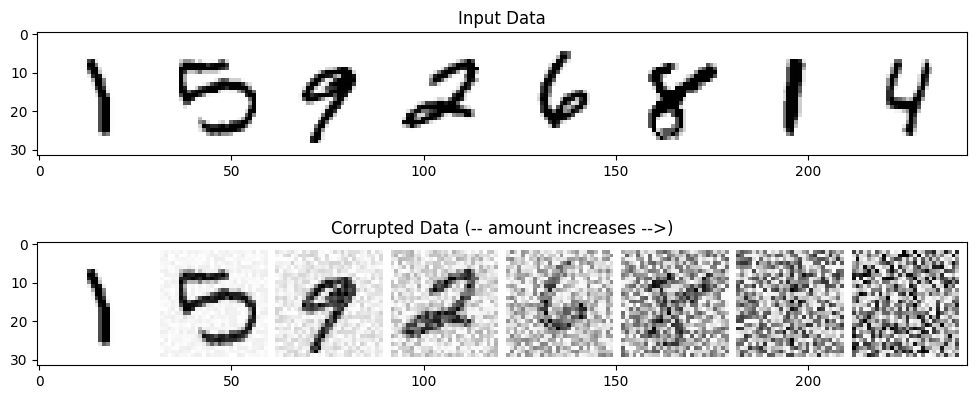

In [4]:
# 绘制输入数据
fig,axs = plt.subplots(2,1,figsize=(12,5))
axs[0].set_title("Input Data")
axs[0].imshow(torchvision.utils.make_grid(x)[0],cmap="Greys")

# 加入噪声
amount = torch.linspace(0,1,x.shape[0]) # 从0到1 -> 退化逐渐强烈直到完全成为噪声
noise_x = corrupt(x,amount)

# 绘制添加噪声后的输出
axs[1].set_title("Corrupted Data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noise_x)[0],cmap="Greys")

## 3. 扩散模型之训练
### 3.1 UNet网络

In [7]:
class BasicUNet(nn.Module):
    def __init__(self,in_channels=1,out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels,32,kernel_size=5,padding=2),
            nn.Conv2d(32,64,kernel_size=5,padding=2),
            nn.Conv2d(64,64,kernel_size=5,padding=2)
        ]) # 下行路径
        self.up_layers = nn.ModuleList([
            nn.Conv2d(64,64,kernel_size=5,padding=2),
            nn.Conv2d(64,32,kernel_size=5,padding=2),
            nn.Conv2d(32,out_channels,kernel_size=5,padding=2)
        ]) # 上行路径
        self.activate = nn.SiLU() # 激活函数
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    
    def forward(self,x):
        h = []
        for i,l in enumerate(self.down_layers):
            x = self.activate(l(x)) # 通过卷积层和激活函数
            if i < 2:
                h.append(x) # 排列供残差链接使用的数据
                x = self.downscale(x) # 进行下采样以适配下一层的输入
            
        for i,l in enumerate(self.up_layers):
            if i > 0: # 选择上行路径的后两层
                x = self.upscale(x) # Upscale上采样
                x += h.pop() # 得到之前排列好的供残差链接使用的数据
            x = self.activate(l(x))
        return x

In [8]:
net = BasicUNet()
x = torch.rand(8,1,28,28)
net(x).shape

torch.Size([8, 1, 28, 28])